In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from local.torch_basics import *
from local.test import *
from local.basics import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc
from local.audio.core import *
from local.audio.augment import *
from local.vision.learner import *
from local.vision.models.xresnet import *
from local.metrics import *

In [ ]:
import torchaudio

# Tutorial: Training a Voice Recognition Model

In [ ]:
p10speakers = Config()['data_path'] / 'ST-AEDS-20180100_1-OS'
URLs.SPEAKERS10 = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
untar_data(URLs.SPEAKERS10, dest=p10speakers)

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

In [ ]:
#Warning this dataset is ~8GB
p250speakers = Config()['data_path'] / '250_speakers'
URLs.SPEAKERS250 = 'https://public-datasets.fra1.digitaloceanspaces.com/250-speakers.tar'
untar_data(URLs.SPEAKERS250, dest=p250speakers)

PosixPath('/home/jupyter/.fastai/data/250_speakers/250-speakers')

In [ ]:
x = AudioGetter("", recurse=True, folders=None)
files_10  = x(p10speakers)
files_250 = x(p250speakers)
#original_aud = AudioItem.create(files[0])

## Datablock and Basic End to End Training on 10 Speakers

In [ ]:
def AudioBlock(cls=AudioItem): return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)

In [ ]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

In [ ]:
cats = [y for _,y in auds.datasource(p10speakers)]

In [ ]:
#verify categories are being correctly assigned
test_eq(min(cats).item(), 0)
test_eq(max(cats).item(), 9)

In [ ]:
#crop 2s from the signal and turn it to a MelSpectrogram with no augmentation
cfg_voice = AudioConfig.Voice()
a2s = AudioToSpec.from_cfg(cfg_voice)
crop_2000ms = CropSignal(2000)
tfms = Pipeline([crop_2000ms, a2s], as_item=True)
dbunch = auds.databunch(p10speakers, item_tfms=tfms, bs=64)

<div class = "alert alert-block alert-warning"><strong>Broken:</strong><br>Show batch is broken as it appears to just be grabbing the data from the sg, and not the sg object itself, but calls the sg's show method which relies on nchannels, which is an object of AudioSpectrogram (part of sg settings but we overrode getattr to make it work like an attribute). This means the items cant show themselves for the batch, but training still works </div>


In [ ]:
#dbunch_cropspec.show_batch(max_n=9)

In [ ]:
dbunch.one_batch()[0].shape

In [ ]:
# credit to Kevin Bird and Hiromi Suenaga for these two lines to adjust a CNN model to take 1 channel input
def alter_learner(learn, in_channels):
    learn.model[0][0].in_channels=in_channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [ ]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

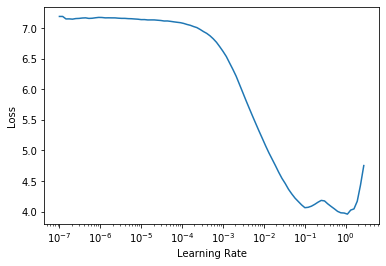

In [ ]:
learn.lr_find()

In [ ]:
#epochs are a bit longer due to the chosen melspectrogram settings
learn.fit_one_cycle(10, lr_max=slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.045846,3.582747,0.346354,00:13
1,0.830040,5.764700,0.242188,00:12
2,0.438936,3.116820,0.502604,00:12
3,0.285329,6.640458,0.320312,00:12
4,0.156109,0.339813,0.908854,00:12
5,0.087593,0.372424,0.891927,00:12
6,0.061826,0.232947,0.928385,00:12
7,0.041161,0.043665,0.986979,00:12
8,0.032756,0.028728,0.992188,00:12
9,0.022816,0.038119,0.990885,00:12


# Training on 250 Speakers

## Baseline

In [ ]:
len(files_250)

44655

In [ ]:
for i in range(10):
    print(random.choice(files_250))

/home/jupyter/.fastai/data/250_speakers/250-speakers/id09230/LRFLM2Mac44/00138.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id09051/oBPMFcURM_Y/00372.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id08999/KidjfGGKncM/00142.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id09034/HFpXHoiHBLQ/00105.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id08971/4OQ8FNaHKgA/00012.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id08901/lDTLFGajOB4/00229.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id09262/NAKirRm2qOg/00076.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id09186/tF0XQPahhZs/00486.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id09071/6j57jBd6uv0/00104.wav
/home/jupyter/.fastai/data/250_speakers/250-speakers/id09048/j5fVbZ1-o1Q/00299.wav


In [ ]:
#lens = stats(files_250)

In [ ]:
get_250speakers_label = lambda x: str(x).split('/')[-3][3:]

In [ ]:
for i in range(10):
    f = random.choice(files_250)
    print("File:",f )
    print("Label:", get_250speakers_label(f))

File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09081/fva4CsJiLRs/00161.wav
Label: 9081
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09156/khoe2BNomEc/00126.wav
Label: 9156
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09147/bIIDSRREZOI/00185.wav
Label: 9147
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id08942/0QFFYN0Xe0E/00009.wav
Label: 8942
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09036/gfa4vAGmimc/00166.wav
Label: 9036
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id08926/IPPtrkelug4/00079.wav
Label: 8926
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09010/qXnfIJVn5HQ/00443.wav
Label: 9010
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09232/GWajiMItc1I/00126.wav
Label: 9232
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id08881/IG78WfLS1ts/00020.wav
Label: 8881
File: /home/jupyter/.fastai/data/250_speakers/250-speakers/id09016/6I_lLzwgvkM/00076.wav
La

In [ ]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=get_250speakers_label)

In [ ]:
dbunch250 = auds.databunch(p250speakers, item_tfms=tfms, bs=64)

In [ ]:
cats = [y for _,y in auds.datasource(p250speakers)]

In [ ]:
#verify categories are being correctly assigned for 250 speakers
test_eq(min(cats).item(), 0)
test_eq(max(cats).item(), 249)

In [ ]:
# Use torchaudio default MelSpectrogram to get a baseline
a2s = AudioToSpec()
crop_4000ms = CropSignal(4000)
tfms = Pipeline([crop_4000ms, a2s], as_item=True)
dbunch = auds.databunch(p250speakers, item_tfms=tfms, bs=256)

In [ ]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

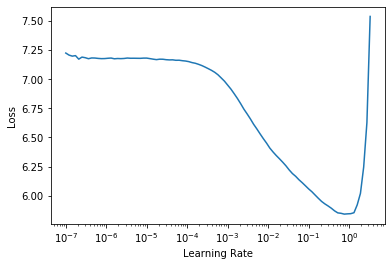

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(2e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.079318,4.239493,0.221364,01:05
1,1.258915,2.491192,0.479566,01:04
2,0.607324,0.916477,0.769231,01:05
3,0.239654,0.370874,0.906729,01:05
4,0.092296,0.299991,0.926884,01:05


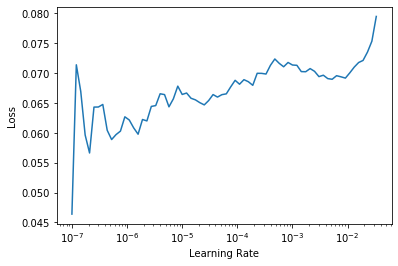

In [ ]:
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.063921,0.305443,0.926996,01:05
1,0.060413,0.289734,0.930467,01:05
2,0.047093,0.291265,0.931811,01:05
3,0.034050,0.281140,0.935170,01:05
4,0.028684,0.277568,0.935058,01:05


## Customize our AudioToSpec Function using a config

In [ ]:
voice_cfg = AudioConfig.Voice()
a2s = AudioToSpec.from_cfg(voice_cfg)
tfms = Pipeline([crop_4000ms, a2s], as_item=True)
# tfms = Pipeline([CropSignal(4000),  a2s, MaskFreq(size=12), MaskTime(size=15), SGRoll()], as_item=True)
dbunch = auds.databunch(p250speakers, item_tfms=tfms, bs=128)

In [ ]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

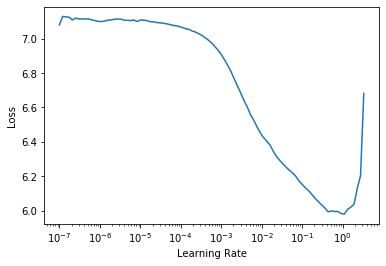

In [ ]:
learn.lr_find()

In [ ]:
# Better results even without fine tuning, but much slower. We need to move a2s to the GPU and 
# then add data augmentation!
learn.fit_one_cycle(5, lr_max=slice(2e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.457882,4.007383,0.263128,03:55
1,0.946617,1.774093,0.591535,03:54
2,0.476260,0.661700,0.829023,03:53
3,0.162349,0.278659,0.935058,03:54
4,0.053187,0.215282,0.951629,03:53


<div class='alert alert-block alert-info'><strong>From Here:</strong><br>
    1. Get transforms on the GPU <br>
    2. Once it's faster test signal and spectrogram augments for speed/efficacy<br>
    3. Fine-tune and see how high we can push results on 250 speakers
</div>


## Imperfect GPU Spectrogram Augmentation

In [ ]:
def MaskFreqBatch(num_masks=1, size=20, start=None, val=None, **kwargs):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Google SpecAugment time masking from https://arxiv.org/abs/1904.08779.'''
        start_ = start
        sg = spectro.clone()
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:,None,None]
        mask_val = channel_mean if val is None else val
        c, y, x = sg.shape[-3:]
        for _ in range(num_masks):
            #print("Mask Val", mask_val)
            #Currently not worrying about getting the channel mean from batchwise implementation
            mask = torch.ones(size, x, device=device).unsqueeze(0).unsqueeze(0) #* mask_val    
            if start_ is None: start_= random.randint(0, y-size)
            if not 0 <= start_ <= y-size:
                raise ValueError(f"Start value '{start_}' out of range for AudioSpectrogram of shape {sg.shape}")
            sg[...,start_:start_+size,:] = mask
            start_ = None
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
cropsig_2000ms = CropSignal(2000)

In [ ]:
def SGRollBatch(max_shift_pct=0.5, direction=0, **kwargs):
    '''Shifts spectrogram along x-axis wrapping around to other side'''
    if int(direction) not in [-1, 0, 1]: 
        raise ValueError("Direction must be -1(left) 0(bidirectional) or 1(right)")
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        nonlocal direction
        direction = random.choice([-1, 1]) if direction == 0 else direction
        sg = spectro.clone()
        c, height, width = sg.shape[-3:]
        roll_by = int(width*random.random()*max_shift_pct*direction)
        sg = sg.roll(roll_by, dims=-1)
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
ds_tfms = Pipeline([cropsig_2000ms, a2s_baseline], as_item=True)
dl_tfms = Pipeline([Cuda(), MaskFreqBatch(), SGRollBatch()], as_item=True)
dbunch = auds.databunch(p, item_tfms=ds_tfms, batch_tfms=dl_tfms, bs=64)
dbunch.show_batch(max_n=9)

In [ ]:
dbunch.one_batch()[0].shape

In [ ]:
learn = Learner(dbunch,
                xresnet18(),  
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
alter_learner(learn)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=2e-2)

## 2nd Attempt with correct mean channel values

In [ ]:
def MaskFreqBatchValue(num_masks=1, size=20, start=None, val=None, **kwargs):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Google SpecAugment time masking from https://arxiv.org/abs/1904.08779.'''
        start_ = start
        sg = spectro.clone()
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:,None,None,None]
        mask_val = channel_mean if val is None else val
        b, c, y, x = sg.shape
        for _ in range(num_masks):
            ones_mask = torch.ones(size=(1, c, size, x), device=device)
            mask = ones_mask * mask_val
            if start_ is None: start_= random.randint(0, y-size)
            if not 0 <= start_ <= y-size:
                raise ValueError(f"Start value '{start_}' out of range for AudioSpectrogram of shape {sg.shape}")
            sg[:,:,start_:start_+size,:] = mask
            start_ = None
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
(torch.ones(size=(64,1,20,128)) * 12).shape

In [ ]:
ds_tfms = Pipeline([cropsig_2000ms, a2s_baseline], as_item=True)
dl_tfms = Pipeline([Cuda(), MaskFreqBatchValue()], as_item=True)
dbunch = auds.databunch(p, item_tfms=ds_tfms, batch_tfms=dl_tfms, bs=64)
dbunch.show_batch(max_n=9)

## 3rd Attempt with correct random placement of mask

In [ ]:
def MaskFreqBatchPlace(num_masks=1, size=20, start=None, val=None, **kwargs):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Google SpecAugment time masking from https://arxiv.org/abs/1904.08779.'''
        start_ = start
        sg = spectro.clone()
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:,None,None,None]
        mask_val = channel_mean if val is None else val
        b, c, y, x = sg.shape
        for _ in range(num_masks):
            ones_mask = torch.ones(size=(1, c, size, x), device=device)
            mask = ones_mask * mask_val
            if start_ is None: start_= random.randint(0, y-size)
            if not 0 <= start_ <= y-size:
                raise ValueError(f"Start value '{start_}' out of range for AudioSpectrogram of shape {sg.shape}")
            start_test = np.arange(0,,1)
            #print("Index: shape", start_test.shape)
            sg[:,:,start_:start_+size,:] = mask
            start_ = None
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
ds_tfms = Pipeline([cropsig_2000ms, a2s_baseline], as_item=True)
dl_tfms = Pipeline([Cuda(), MaskFreqBatchPlace()], as_item=True)
dbunch = auds.databunch(p, item_tfms=ds_tfms, batch_tfms=dl_tfms, bs=4)
dbunch.show_batch(max_n=9)

In [ ]:
(torch.ones(size=(64,1,20,128)) * 12).shape

In [ ]:
fake_batch = torch.stack([CropTime(2000)(a2s(AudioItem.create(files[i]))) for i in range(64)])

In [ ]:
fake_batch.shape

In [ ]:
index = np.array([2,4,6,8], dtype=np.intp)

In [ ]:
index + 20

In [ ]:
fake_batch[:,:,index:index+20,:]

In [ ]:
fake_batch[:,:,torch.arange(0, 7).long(),:].shape